# Dimensionality Reduction

## The Problem

There is an interesting tradeoff between model performance and a feature's dimensionality:
![http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/](images/dimensionality_vs_performance.png)

>*If the amount of available training data is fixed, then overfitting occurs if we keep adding dimensions. On the other hand, if we keep adding dimensions, the amount of **training data needs to grow exponentially fast to maintain the same coverage** and to avoid overfitting* ([Computer Vision for Dummies](http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)).

![http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/](images/curseofdimensionality.png)

### Multi-Collinearity

In many cases, there is a high degree of correlation between many of the features in a dataset. For instance, suppose that you


## Sparsity

- High dimensionality increases the sparsity of your features (**what NLP techniques have we used that illustrate this point?**)
- The density of the training samples decreases when dimensionality increases:
- Distance measures (Euclidean, for instance) start losing their effectiveness, because there isn't much difference between the max and min distances in higher dimensions.
- Many models that rely upon assumptions of Gaussian distributions (like OLS linear regression), Gaussian mixture models, Gaussian processes, etc. become less and less effective since their distributions become flatter and "fatter tailed".
![http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/](images/distance-asymptote.png)

What is the amount of data needed to maintain **20% coverage** of the feature space? For 1 dimension, it is **20% of the entire population's dataset**. For a dimensionality of $D$:

$$
X^{D} = .20
$$
$$
(X^{D})^{\frac{1}{D}} = .20^{\frac{1}{D}}
$$
$$
X = \sqrt[D]{.20}
$$
You can approximate this as 
```python
def coverage_requirement(requirement, D):
    return requirement ** (1 / D)

x = []
y = []
for d in range(1,20):
    y.append(coverage_requirement(0.10, d))
    x.append(d)
    
import matplotlib.pyplot as plt

plt.plot(x,y)
plt.xlabel("Number of Dimensions")
plt.ylabel("Appromximate % of Population Dataset")
plt.title("% of Dataset Needed to Maintain 10% Coverage of Feature Space")
plt.show()
```
<img src="coverage-needed.png" width="500">

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
reviews = pd.read_csv("mcdonalds-yelp-negative-reviews.csv", encoding='latin-1')
reviews = open("poor_amazon_toy_reviews.txt", encoding='latin-1')

#text = reviews["review"].values
text = reviews.readlines()


vectorizer = CountVectorizer(ngram_range=(3,3), min_df=0.01, max_df=0.75, max_features=200)
# tokenize and build vocab
vectorizer.fit(text)
vector = vectorizer.transform(text)
features = vector.toarray()
features_df = pd.DataFrame(features, columns=vectorizer.get_feature_names())

correlations = features_df.corr()
correlations_stacked = correlations.stack().reset_index()
#set column names
correlations_stacked.columns = ['Bi-Gram 1','Bi-Gram 2','Correlation']
correlations_stacked = correlations_stacked[correlations_stacked["Correlation"] < 1]
correlations_stacked = correlations_stacked.sort_values(by=['Correlation'], ascending=False)
correlations_stacked.head()

,Bi-Gram 1,Bi-Gram 2,Correlation
43,don waste your,waste your money,0.777888
197,waste your money,don waste your,0.777888
82,of the box,out of the,0.609369
110,out of the,of the box,0.609369
123,this for my,my year old,0.078176


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)
sns.heatmap(correlations)

# Principle Component Analysis

If you have an original matrix $Z$, you can decompose this matrix into two smaller matrices $X$ and $Q$. 

## Important Points:

- Multiplying a vector by a matrix typically changes the direction of the vector. For instance:
<figure>
  <img src="images/multvector.png" alt="my alt text"/>
    <figcaption><a href="https://lazyprogrammer.me/tutorial-principal-components-analysis-pca">Lazy Programmer- 
        Tutorial to PCA</a></figcaption>
</figure>

However, there are eigenvalues λ and eigenvectors $v$ such that

$$
\sum{X}v = \lambda v
$$

Multiplying the eigenvectors $v$ with the eigenvalue $\lambda$ does not change the direction of the eigenvector.

Multiplying the eigenvector $v$ by the covariance matrix $\sum{X}$ also does not change the direction of the eigenvector.

If our data $X$ is of shape $N \times D$, it turns out that we have $D$ eigenvalues and $D$ eigenvectors. This means we can arrange the eigenvalues $\lambda$ in decreasing order so that

$$
\lambda_3 > \lambda_2 > \lambda_5
$$

In this case, $\lambda_3$ is the largest eigenvalue, followed by $\lambda_2$, and then $\lambda_5$. Then, we can arrange 

We can also rearrange the eigenvectors the same: $v_3$ will be the first column, $v_2$ will be the second column, and $v_5$ will be the third column.

We'll end up with two matrices $V$ and $\Lambda$:
<figure>
  <img src="images/pca1.png" alt="my alt text"/>
    <figcaption><a href="https://lazyprogrammer.me/tutorial-principal-components-analysis-pca">Lazy Programmer- 
        Tutorial to PCA</a></figcaption>
</figure>

In [41]:
# what is the shape of our features?
features.shape

(12700, 15)

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

Z = pca.fit_transform(features)

# what is the shape of Z?
Z.shape

(12700, 4)

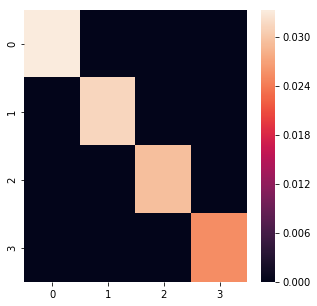

In [43]:
# what will happen if we take the correlation matrix and covariance matrix of our new reduced features?
import numpy as np
covariances = pd.DataFrame(np.cov(Z.transpose()))
plt.rcParams["figure.figsize"] = (5,5)
sns.heatmap(covariances)

In [44]:
pca = PCA(n_components=2)
Z_two_dimensions = pca.fit_transform(features)
Z_two_dimensions

array([[ 0.19584061, -0.05193457],
       [-0.03890385, -0.02632155],
       [-0.03890385, -0.02632155],
       ...,
       [-0.03890385, -0.02632155],
       [-0.03890385, -0.02632155],
       [-0.03890385, -0.02632155]])

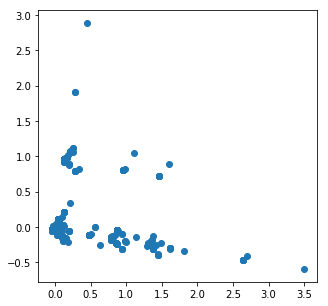

In [45]:
import matplotlib.pyplot as plt

plt.scatter(Z_two_dimensions[:,0], Z_two_dimensions[:, 1])
reduced_features_df = pd.DataFrame(Z_two_dimensions, columns=["x1", "x2"])
reduced_features_df["text"] = text
reduced_features_df.to_csv("reduced_features.csv")

# Singular Value Decomposition

Given an input matrix $A$, we want to try to represent it instead as three smaller matrices $U$, $\sum$, and $V$. Instead of **$n$ original terms**, we want to represent each document as **$r$ concepts** (other referred to as **latent dimensions**, or **latent factors**):
<figure>
  <img src="images/svd.png" alt="my alt text"/>
    <figcaption><i>
        <a href="https://www.youtube.com/watch?v=P5mlg91as1c">Mining of Massive Datasets - Dimensionality Reduction: Singular Value Decomposition</a> by Leskovec, Rajaraman, and Ullman (Stanford University)</i></figcaption>
</figure>

Here, **$A$ is your matrix of word vectors** - you could use any of the word vectorization techniques we have learned so far, include one-hot encoding, word count, TF-IDF.

- $\sum$ will be a **diagonal matrix** with values that are positive and sorted in decreasing order. Its value indicate the **variance (information encoded on that new dimension)**- therefore, the higher the value, the stronger that dimension is in capturing data from A, the original features. For our purposes, we can think of the rank of this $\sum$ matrix as the number of desired dimensions. Instance, if we want to reduce $A$ from shape $1020 x 300$ to $1020 x 10$, we will want to reduce the rank of $\sum$ from 300 to 10.

- $U^T U = I$ and $V^T V = I$

## Measuring the Quality of the Reconstruction

A popular metric used for measuring the quality of the reconstruction is the [Frobenius Norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm). When you explain your methodology for reducing dimensions, usually managers / stakeholders will want to some way to compare multiple dimensionality techniques' ability to quantify its ability to retain information but trim dimensions:

$$
\begin{equation}
||A_{old}-A_{new}||_{F} = \sqrt{\sum_{ij}{(A^{old}_{ij}- A^{new}_{ij}}})^2
\end{equation}
$$

## Heuristic Step for How Many Dimensions to Keep

1. Sum the $\sum$ matrix's diagonal values: 
$$
\begin{equation}
\sum_{i}^{m}\sigma_{i}
\end{equation}
$$

2. Define your threshold of "information" (variance) $\alpha$ to keep: usually 80% to 90%. 

3. Define your cutoff point $C$: $$
\begin{equation}
C = \sum_{i}^{m}\sigma_{i} \alpha
\end{equation}
$$

4. Beginning with your largest singular value, sum your singular values $\sigma_{i}$ until it is greater than C. Retain only those dimensions.

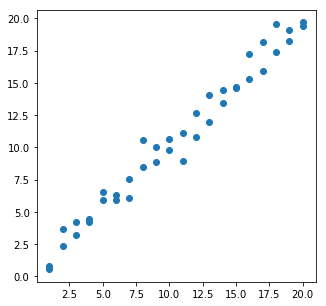

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
x = np.linspace(1,20, 20) # create the first dimension
x = np.concatenate((x,x))
y = x + np.random.normal(0,1, 40) # create the second dimension
z = x + np.random.normal(0,2, 40) # create the third dimension
a = x + np.random.normal(0,4, 40) # create the fourth dimension
plt.scatter(x,y) # plot just the first two dimensions
plt.show()

In [26]:
A = np.stack([x,y,z,a]).T
A

array([[ 1.        ,  0.77950175,  0.7677888 , -0.56338469],
       [ 2.        ,  2.37168063,  2.68471589,  5.07651543],
       [ 3.        ,  4.23624726,  5.41206404,  6.0099617 ],
       [ 4.        ,  4.46378345,  4.44011107,  9.75428485],
       [ 5.        ,  6.50663634,  4.66200827,  4.11785887],
       [ 6.        ,  5.94101546, 10.02615748,  9.45905519],
       [ 7.        ,  6.08581691,  0.47947543,  9.33775111],
       [ 8.        ,  8.50611795,  4.76759185,  2.58313411],
       [ 9.        ,  8.85808728, 11.924234  ,  3.16806057],
       [10.        ,  9.81238686, 11.75431427,  9.3688049 ],
       [11.        ,  8.91639482, 14.3247862 , 12.86762692],
       [12.        , 10.82815483,  9.81102502, 17.17389241],
       [13.        , 11.97544391, 12.74739555, 13.85953691],
       [14.        , 14.44142881, 13.73807306, 12.38912932],
       [15.        , 14.6098057 , 16.54791873, 13.84012328],
       [16.        , 15.33512682, 14.80703823, 20.31090617],
       [17.        , 15.

In [47]:
D = 1
U, s, V = svd(A)
print(f"s is {s}\n")
print(f"U is {U}\n")
print(f"V is {V}")

s is [152.86974397  21.23629493  10.8533152    4.10757824]

U is [[-0.0065041   0.05469218 -0.03365372 ... -0.22239603 -0.25909183
  -0.25717117]
 [-0.03966881 -0.1058881   0.07421117 ... -0.26639667  0.15604784
   0.0815931 ]
 [-0.06113708 -0.05823958  0.14883772 ... -0.10575752 -0.16214804
   0.03279713]
 ...
 [-0.24577592  0.08393435  0.02374991 ...  0.87896565 -0.02911555
  -0.03335981]
 [-0.24769877  0.12976656  0.13040048 ... -0.03325364  0.88036094
  -0.06124731]
 [-0.26632272 -0.1296538  -0.01417942 ... -0.02760683 -0.0678463
   0.90535574]]

V is [[-0.49363198 -0.4960859  -0.51307612 -0.49696996]
 [ 0.16544881  0.22035026  0.45036767 -0.84925934]
 [-0.45544321 -0.47763446  0.73066685  0.17482211]
 [ 0.72216733 -0.69080378  0.00691485 -0.0348808 ]]


In [ ]:
s[D:] = 0
S = np.zeros((A.shape[0], A.shape[1]))
S[:A.shape[1], :A.shape[1]] = np.diag(s)
A_reconstructed = U.dot(S.dot(V))
np.sum((A_reconstructed - A) ** 2) ** (1/2) # Frobenius norm
# reconstruct matrix
U.dot(S)

# Exercise (20 minutes)

**1. Use the Amazon Fire Dataset**:

- Vectorize the documents with either word embeddings or TF-IDF
- Reduce the # of dimensions to 2
- Visualize the results on a scatter plot and identify clusters of similar product reviews

**2. Challenge:** In the example we have just done, we modelled the relationship between `x` and `y` as a linear relationship. Your manager does not think SVD works as well with non-linear relationships, and is skeptical because many of the social media marketing data she sees has non-linear relationships (ie. the number of times a post was seen versus the number of reactions it got). Investigate what the impact of non-linear relationships on SVD performance is in terms of:

- **# of dimensions needed to capture 90% of the variance**
- **Frobenius Norm** reconstruction error

If SVD is not significantly affected by non-linearity, **explain to your manager why**.

If SVD is significantly affected, **evaluate whether or not SVD can still be used as a dimensionality reduction technique**.

In [65]:
# define a matrix
A = np.array([[1, 2], [3, 4], [5, 6]])
print(A)
# Singular-value decomposition
U, s, VT = svd(A)
# create m x n Sigma matrix
Sigma = np.zeros((A.shape[0], A.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:A.shape[1], :A.shape[1]] = np.diag(s)
Sigma

[[1 2]
 [3 4]
 [5 6]]


array([[9.52551809, 0.        ],
       [0.        , 0.51430058],
       [0.        , 0.        ]])